In [1]:
import numpy as np
import pandas as pd

import os
import json
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

In [2]:
data_path = Path('/home/koke_cacao/Documents/Koke_Cacao/Python/WorkSpace/RedstoneTorch/data/arc_dataset/data/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

training_tasks = sorted(os.listdir(training_path))
evaluation_tasks = sorted(os.listdir(evaluation_path))

In [3]:
def plot_one(task, ax, i,train_or_test,input_or_output):
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    input_matrix = task[train_or_test][i][input_or_output]
    input_matrix = np.asarray(input_matrix)
    #print(input_matrix)
    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True,which='both',color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' '+input_or_output)

def plot_task(task):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """    
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(3*num_train,3*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i],i,'train','input')
        plot_one(task, axs[1,i],i,'train','output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    fig, axs = plt.subplots(2, num_test, figsize=(3*num_test,3*2))
    if num_test==1: 
        plot_one(task, axs[0],0,'test','input')
        plot_one(task, axs[1],0,'test','output')     
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i],i,'test','input')
            plot_one(task, axs[1,i],i,'test','output')  
    plt.tight_layout()
    plt.show()


#0 - 007bbfb7.json


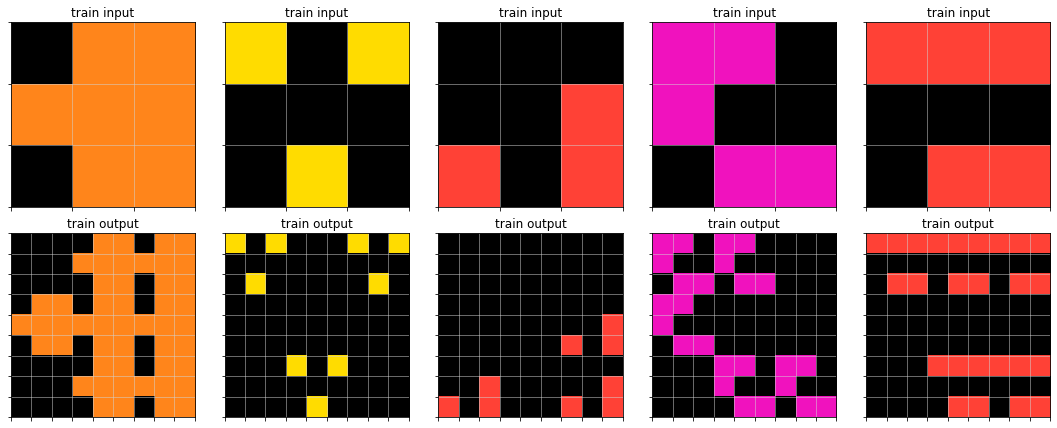

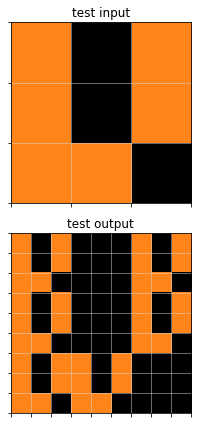

#1 - 00d62c1b.json


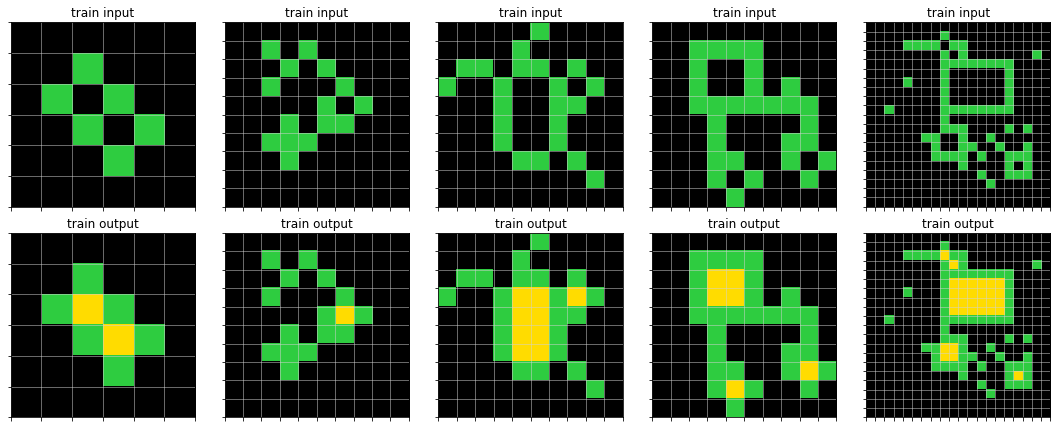

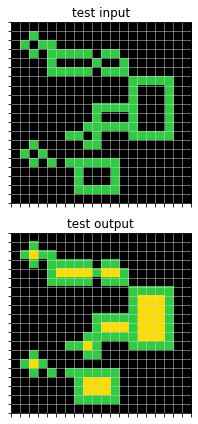

#2 - 017c7c7b.json


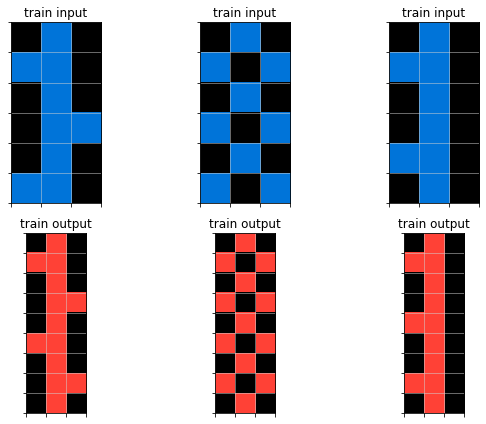

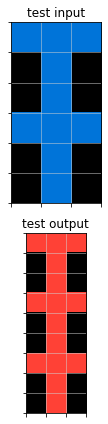

#3 - 025d127b.json


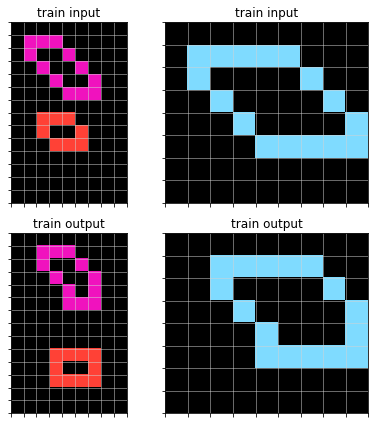

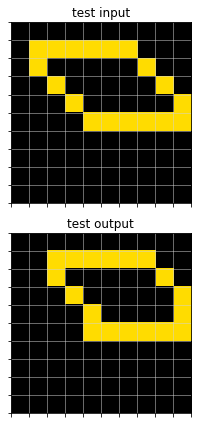

#4 - 045e512c.json


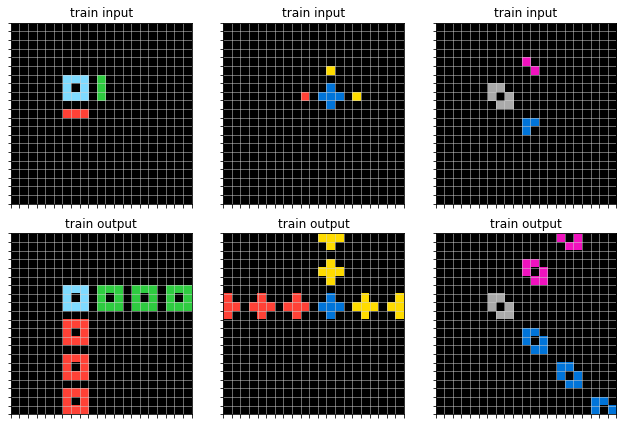

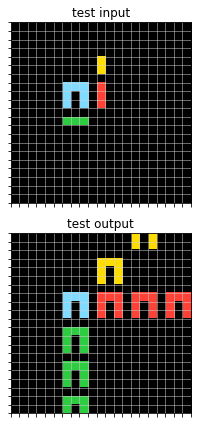

In [4]:
SELECTED_TASKS = training_tasks[:5]

for i, json_file in enumerate(SELECTED_TASKS):
    with open(str(training_path / json_file), 'r') as f:
        task = json.load(f)
    
    print("#{} - {}".format(i, json_file))
    plot_task(task)

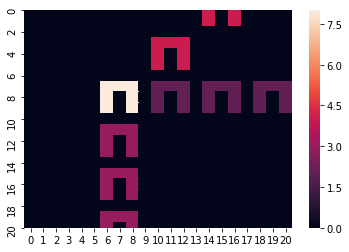

In [5]:
# note: all augmentation should apply to all X,Y pairs in a rule

def symmetry_flip_x(matrix):
    return np.flip(matrix, 0)

def symmetry_flip_y(matrix):
    return np.flip(matrix, 1)

def symmetry_rotate(matrix, k=1):
    return np.rot90(matrix, k)

# note: this augmentation must apply to both X and Y together
# note: this function is no longer meaningful with the presence of `def decentralizing()`
def switching_color(matrix, color=[1,2,3,4,5,6,7,8,9]):
    replace = np.random.choice(color, size=len(color), replace=False, p=None)
    for n in range(len(color)):
        matrix[matrix==color[n]]=replace[n]
    return matrix

# note: this augmentation recommand apply to both X and Y together
def zoom(matrix, i=2, j=2):
    return np.kron(matrix, np.ones((i,j)))

def decentralizing(matrix, color=[1,2,3,4,5,6,7,8,9]):
    out = None
    for i in color:
        colored = np.zeros(matrix.shape)
#         print(np.where(matrix==i))
        colored[np.where(matrix==i)] = 1
        if colored.sum() is not None and colored.sum() != 0:
#             print(colored.sum())
            out = np.concatenate((out, [colored]), axis=0) if out is not None else [colored]
#             print(out)
    return out

# note: if this function is used by model's output, loss should be adjusted accordingly
def centraization(matrix):
    for i, colored in enumerate(matrix):
        matrix[i] = colored*(i+1)
    return matrix.sum(axis=0)

def zero_padding(matrix, shape, offset):
    """
    array: Array to be padded
    reference: Reference array with the desired shape
    offsets: list of offsets (number of elements must be equal to the dimension of the array)
    """
    # Create an array of zeros with the reference shape
    result = np.zeros(shape)
    # Create a list of slices from offset to offset + shape in each dimension
    insertHere = [slice(offset[dim], offset[dim] + matrix.shape[dim]) for dim in range(matrix.ndim)]
    # Insert the array in the result at the specified offsets
    result[insertHere] = matrix
    return result

input = np.asarray([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,4,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,4,0,4,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,4,0,4,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,8,8,8,0,2,2,2,0,2,2,2,0,2,2,2]
,[0,0,0,0,0,0,8,0,8,0,2,0,2,0,2,0,2,0,2,0,2]
,[0,0,0,0,0,0,8,0,8,0,2,0,2,0,2,0,2,0,2,0,2]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0]
,[0,0,0,0,0,0,3,0,3,0,0,0,0,0,0,0,0,0,0,0,0]])

# print(input)
sns.heatmap(input)

/home/koke_cacao/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


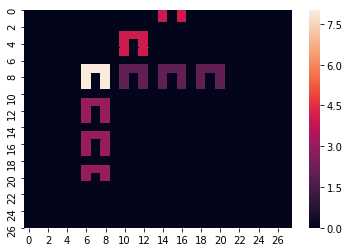

In [6]:
output = zero_padding(input, (28, 28), [0, 0])
sns.heatmap(output)

# output = decentralizing(input)
# # print(output)
# sns.heatmap(centraization(output))

In [7]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils import data
from torch.autograd import Variable

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

TRAIN_SEED = 19


random.seed(TRAIN_SEED)
np.random.seed(TRAIN_SEED)
torch.manual_seed(TRAIN_SEED)
torch.cuda.manual_seed_all(TRAIN_SEED)

In [54]:
# The task can be thought as best compression finding for the images in a specific rule
# 1. prepare a table
# 2. put background
# 3. put some sauce and repeatly using it

# working memory can see small part of selected picture? so choose wisely

# look at data -> do task -> eval error -> 

# all pad to 28x28 first

class ARCDataset(data.Dataset):
    def __init__(self):
        
        def get_matrix(task, i, train_or_test, input_or_output):
            return np.asarray(task[train_or_test][i][input_or_output])
    
        SELECTED_TASKS = training_tasks[:]
        
        train_input = [[]]*len(SELECTED_TASKS)
        train_output = [[]]*len(SELECTED_TASKS)
        test_input = [[]]*len(SELECTED_TASKS)
        test_output = [[]]*len(SELECTED_TASKS)
        
        for task_number, json_file in enumerate(SELECTED_TASKS):
            with open(str(training_path / json_file), 'r') as f:
                task = json.load(f)
            
            num_train = len(task['train'])
            for i in range(num_train):
                if i > 4: print("ERROR, num_train for task {} is {}".format(task_number, num_train))
                train_input[task_number].append(get_matrix(task,i,'train','input'))
                train_output[task_number].append(get_matrix(task,i,'train','output'))
                
            num_test = len(task['test'])
            if num_test==1:
                test_input[task_number].append(get_matrix(task,0,'test','input'))
                test_output[task_number].append(get_matrix(task,0,'test','output'))
            else:
                print("ERROR, len(test) image for task {} is {}".format(task_number, num_test))
                for i in range(num_test):
                    test_input[task_number].append(get_matrix(task,i,'test','input'))
                    test_output[task_number].append(get_matrix(task,i,'test','output'))
        print("loaded {} rules".format(len(train_output)))
        
        self.unordered_train_input = [i for l in train_input for i in l]
#         del train_input
        self.unordered_train_output = [i for l in train_output for i in l]
#         del train_output
        self.unordered_test_input = [i for l in test_input for i in l]
#         del test_input
        self.unordered_test_output = [i for l in test_output for i in l]
#         del test_output
        
        print("loaded {} unordered_train_input".format(len(self.unordered_train_input)))
        print("loaded {} unordered_train_output".format(len(self.unordered_train_output)))
        print("loaded {} unordered_test_input".format(len(self.unordered_test_input)))
        print("loaded {} unordered_test_output".format(len(self.unordered_test_output)))
        
        self.train_indexer = np.random.choice(range(len(self.unordered_train_input)), size=len(self.unordered_train_input), replace=False, p=None)
        self.test_indexer = np.random.choice(range(len(self.unordered_test_input)), size=len(self.unordered_test_input), replace=False, p=None)
        
    def __len__(self):
        # TODO
        return len(self.train_indexer)
    
    def __getitem__(self, indice):
        # TODO
#         print("evoke indice {} -> {}".format(indice, self.train_indexer[indice]))
        return self.unordered_train_input[self.train_indexer[indice]]
    
    def augmentation(self, matrix):
        return np.expand_dims(zero_padding(matrix, (30, 30), [0, 0]), axis=0)/9
        
dataset = ARCDataset()

ERROR, num_train for task 47 is 6
ERROR, len(test) image for task 47 is 2
ERROR, num_train for task 49 is 8
ERROR, num_train for task 49 is 8
ERROR, num_train for task 49 is 8
ERROR, len(test) image for task 52 is 2
ERROR, num_train for task 55 is 7
ERROR, num_train for task 55 is 7
ERROR, len(test) image for task 55 is 3
ERROR, len(test) image for task 71 is 2
ERROR, num_train for task 102 is 6
ERROR, len(test) image for task 102 is 2
ERROR, len(test) image for task 123 is 2
ERROR, num_train for task 185 is 10
ERROR, num_train for task 185 is 10
ERROR, num_train for task 185 is 10
ERROR, num_train for task 185 is 10
ERROR, num_train for task 185 is 10
ERROR, len(test) image for task 185 is 2
ERROR, num_train for task 246 is 6
ERROR, num_train for task 256 is 6
ERROR, num_train for task 273 is 6
ERROR, len(test) image for task 297 is 2
ERROR, num_train for task 333 is 7
ERROR, num_train for task 333 is 7
ERROR, len(test) image for task 333 is 2
ERROR, len(test) image for task 337 is 2


In [59]:
from torch.utils.data.dataloader import default_collate

def train_collate(batch):
    new_batch = []
    for img in batch:
        new_batch.append(dataset.augmentation(img))
    return default_collate(new_batch)

# TODO: not optimized sampler, pin_memory, and drop_last
dataloader = data.DataLoader(dataset, batch_size=1, shuffle=False, batch_sampler=None,
                            num_workers=4, collate_fn=train_collate, pin_memory=False, drop_last=False)


In [60]:
# define the NN architecture
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 3 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 4), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)

        ## decoder layers ##
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(16, 1, 4, stride=2)

    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        # output layer (with sigmoid for scaling from 0 to 1)
        x = F.sigmoid(self.t_conv2(x))

        return x

# initialize the NN
model = Autoencoder()
print(model)

Autoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2))
  (t_conv2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
)


In [62]:
#define our optimizer and loss function
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [64]:
losses = []
EPOCHS = 5
for epoch in range(EPOCHS):
    
    for batch_idx, img in enumerate(dataloader):
#         print(img.size)
        img = torch.autograd.Variable(img).float()
        optimizer.zero_grad()
        pred = model(img)
        
#         print(pred.shape, img.shape)
        loss = loss_func(pred, img)
        
        losses.append(loss.cpu().data.item())
        
        # Backpropagation
        loss.backward()
        
        optimizer.step()
        
        
        # Display
        if batch_idx % 100 == 1:
            print('\r Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch+1,
                EPOCHS,
                batch_idx * len(img), 
                len(dataloader.dataset),
                100. * batch_idx / len(dataloader), 
                loss.cpu().item()), 
                end='')

/home/koke_cacao/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/koke_cacao/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/home/koke_cacao/miniconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array ind

 Train Epoch: 1/5 [5501/520400 (1%)]	Loss: 0.003204

KeyboardInterrupt: 